In [2]:
import numpy as np
import matplotlib.pyplot as plt

#Constants
faraday_constant = 96485
anode_stoichiometry = 1.5
cathode_stoichiometry = 3.0
anode_transfer_coefficient = 0.5
cathode_transfer_coefficient = 1.0
u_gas_constant = 8.314
hhv = 286000
ds_pressure = 1.0
ds_temperature = 298.15
heat_loss_ratio = 0.2
number_of_electrons = 2.0
anode_drygas_fraction = 0.0
cathode_drygas_fraction = 3.76
cell_temperature = 50 # in C
max_current_density = 2.0 
membrane_thickness = 0.018

# Variables
cell_pressure = np.arange(3.0, 5.1, 0.5)
current_density = np.arange(0.1,2.0,0.1)

In [5]:
def water_saturation_pressure(): # Find water saturation temperature
    wsp = -2.1794 + (0.02953 * cell_temperature) - (9.1837 * (10**(-5)) * (cell_temperature**2)) + (1.4454 * (10**(-7)) * (cell_temperature**3))
    wsp = 10**wsp
    return wsp

def water_mole_fr_cathode(): # Find water mole fraction for cathode. Needs cell pressure array as input.
    wmfc = []
    water_sat_prr = water_saturation_pressure()
    for i in cell_pressure:
        wmfc.append(water_sat_prr / i)
    return wmfc

def water_mole_fr_anode(): # Find water mole fraction for anode. Needs cell pressure array as input.
    wmfa = []
    water_sat_prr = water_saturation_pressure()
    for i in cell_pressure:
        wmfa.append(water_sat_prr / i)
    return wmfa

def mole_fraction_h2(): # Find mole fraction for h2
    mole_fr_h2 = []
    numerator =  water_mole_fr_anode()
    denominator = 1 + ((anode_drygas_fraction/2) * (1 + (anode_stoichiometry / (anode_stoichiometry - 1))))
    for i in numerator:
        mole_fr_h2.append((1 - i) / denominator)
    return mole_fr_h2

def mole_fraction_o2(): # Find mole fraction for o2
    mole_fr_o2 = []
    numerator =  water_mole_fr_cathode()
    denominator = 1 + ((cathode_drygas_fraction/2) * (1 + (cathode_stoichiometry / (cathode_stoichiometry - 1))))
    for i in numerator:
        mole_fr_o2.append((1 - i) / denominator)
    return mole_fr_o2

def partial_pressure_h2(): # Find partial pressure of h2. Needs cell pressure array as input.
    mole_fr = mole_fraction_h2()
    partial_pressure = []
    j = 0
    for i in mole_fr:
        partial_pressure.append(i * cell_pressure[j])
        j = j+1
    return partial_pressure

def partial_pressure_o2(): # Find partial pressure of o2. Needs cell pressure array as input.
    mole_fr = mole_fraction_o2()
    partial_pressure = []
    j = 0
    for i in mole_fr:
        partial_pressure.append(i * cell_pressure[j])
        j = j+1
    return partial_pressure

def v_rev(): # Find reversible voltage. Needs cell temp for input.
    cell_temp_k = cell_temperature + 273.15
    E = 1.229 - (8.5 * (10**(-4)) * (cell_temp_k - 298.15)) + (4.3085 * (10**(-5)) * (cell_temp_k * ((np.log(partial_pressure_h2())) + 0.5 * np.log(partial_pressure_o2()))))
    return E

def exchange_current_density(): # Find exchange current density. needs partial pressure of o2 as input.
    cell_prr = partial_pressure_o2()
    e_current_density = []
    for i in cell_prr:
        e_current_density.append(1.27 * 10**(-8) * np.exp(2.06 * i))
    return e_current_density

def v_activation_anode():
    ecd = exchange_current_density()
    cd = current_density
    v_act_anode = np.zeros((len(ecd), len(cd)))
    for i in range(len(ecd)):
        for j in range(len(cd)):
          v_act_anode[i, j] = ((u_gas_constant * (cell_temperature + 273.15)) / (number_of_electrons * faraday_constant * anode_transfer_coefficient) * np.log(cd[j] / ecd[i]))
    return v_act_anode

def v_activation_cathode():
    ecd = exchange_current_density() 
    cd = current_density
    v_act_cathode = np.zeros((len(ecd), len(cd)))
    for i in range(len(ecd)):
        for j in range(len(cd)):
          v_act_cathode[i, j] = ((u_gas_constant * (cell_temperature+273.15)) / (number_of_electrons * faraday_constant * cathode_transfer_coefficient) * np.log(cd[j] / ecd[i]))
    return v_act_cathode

def water_activity():
    tmp_a = [i / water_saturation_pressure() for i in cell_pressure]
    a = np.multiply(tmp_a, water_mole_fr_cathode())
    mwc = []
    for i in np.arange(len(cell_pressure)):
        if a[i] <= 1:
            mwc = 0.043 + (17.81 * a) - (39.85 * a**2) + (39.85 * a**3)
        elif a[i] > 1:
            mwc[i] = 14 + (1.4 * (a - 1))    
        else:
            print('here')
    return mwc

def membrane_conductivity():
    memb_conductivity = (0.005139 * water_activity() - 0.00326) * np.exp(1268*((1 /303) - (1/(cell_temperature + 273.15))))
    return memb_conductivity

def cell_resistance():
    v_cell_res = (membrane_thickness / membrane_conductivity())
    return v_cell_res 

def v_ohmic(): # current density array yap
    cd = current_density
    cr = cell_resistance()
    v_ohm = np.zeros((len(cd), len(cr)))  # Pre-allocate the output array
    for i in np.arange(len(current_density)):
        for j in np.arange(len(cr)):
            v_ohm[i, j] = (cd[i] * cr[j])
    return v_ohm

def reactant_partial_pressure():
    rpp = []
    for i in partial_pressure_o2():
        if (i / 0.1173 + water_saturation_pressure()) < 2:
            rpp.append((7.16 * 10**(-4) * (cell_temperature + 273.15) - 0.622) * (i / 0.1173 + water_saturation_pressure()) + (-1.45 * 10**(-3) * (cell_temperature + 273.15) + 1.68))
        else:
            rpp.append((8.66 * 10**(-5) * (cell_temperature + 273.15) - 0.068) * (i / 0.1173 + water_saturation_pressure()) + (-1.6 * 10**(-4) * (cell_temperature + 273.15) + 0.54))
    return rpp

def v_concentration():
    rpp = reactant_partial_pressure()
    cd = current_density
    v_conn = np.zeros((len(rpp), len(cd)))
    for i in range(len(rpp)):
        for j in range(len(cd)):
          v_conn[i, j] = (cd[j] * ((rpp[i] * (cd[j] / max_current_density)) ** 2))
    return v_conn

def v_activation():
    v_act_anode = v_activation_anode()
    v_act_cathode = v_activation_cathode()
    v_act = np.zeros((len(v_act_anode), len(v_act_cathode[0])))
    for i in range(len(v_act_anode)):
        for j in range(len(v_act_anode[0])):
            v_act[i, j] = (v_act_anode[i, j] + v_act_cathode[i, j])
    return v_act
    
def v_irreversible(): # Calculate irreversible voltage drop
    v_act = v_activation() 
    v_conc = v_concentration()
    v_ohm = v_ohmic()
    v_irrev = np.zeros((len(v_act), len(v_act[0])))  # Pre-allocate the output array
    for i in range(len(v_act)): # Loop of the first dimension 
        for j in range(len(v_act[0])): # Loop of the second dimension 
          v_irrev[i, j] = (v_act[i, j] + v_conc[i, j] + v_ohm[j, 0])
    return v_irrev

def net_voltage():
    v_ir = v_irreversible()
    v_r = v_rev()
    net_v = np.zeros((len(v_ir), len(v_ir[0])))
    for i in range(len(v_ir)):
        for j in range(len(v_ir[0])):
            net_v[i, j] = (v_r[i] - v_ir[i, j])
    return net_v

def power():
    net_v = net_voltage()
    cd = current_density
    power = np.zeros((len(net_v), len(net_v[0])))
    for i in range(len(net_v)): #5
        for j in range(len(net_v[0])): #19
            power[i, j] = (net_v[i, j] * cd[j])
    return power

def molar_flow_rate_h2_in():
    cd = current_density 
    flow_rate_h2 = []
    for i in range(len(cd)):
        flow_rate_h2.append((cd[i] / (2 * faraday_constant))/ 0.8)
    return flow_rate_h2

def energy_efficiency():
    pw = power()
    mfr = molar_flow_rate_h2_in()
    ee = np.zeros((len(pw), len(pw[0])))
    for i in range(len(pw)):
        for j in range(len(pw[0])):
            ee[i, j] = (pw[i, j] / (mfr[j] * hhv))
    return ee

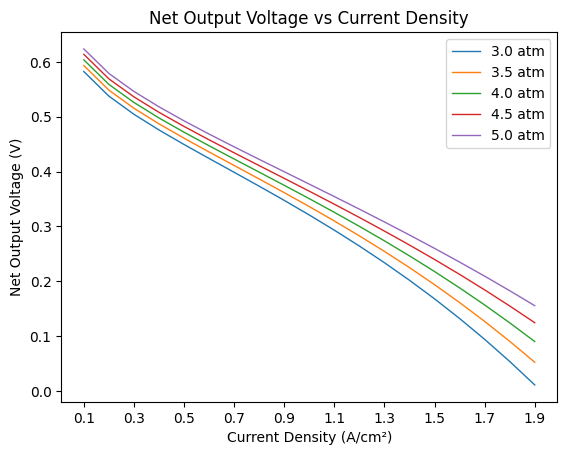

In [28]:
plt.title("Net Output Voltage vs Current Density")
plt.xlabel("Current Density (A/cm\u00b2)")
plt.ylabel("Net Output Voltage (V)")

atm = 3.0
net_volt = net_voltage()
for i in np.arange(len(net_volt)):
    plt.plot(current_density, net_volt[i], linewidth=1, label=f"{atm} atm")
    atm = atm + 0.5
plt.xticks(np.arange(min(current_density), max(current_density)+0.1, 0.2))
plt.legend(loc="upper right")
plt.savefig("outputVsCurrent.png", dpi=400)
plt.show()

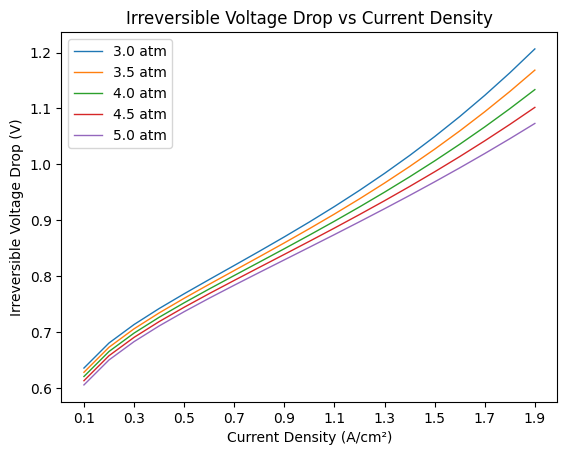

In [20]:
plt.title("Irreversible Voltage Drop vs Current Density")
plt.xlabel("Current Density (A/cm\u00b2)")
plt.ylabel("Irreversible Voltage Drop (V)")


irrev = v_irreversible()
atm = 3.0
for i in np.arange(len(irrev)):
    plt.plot(current_density, irrev[i], linewidth=1, label=f"{atm} atm")
    atm = atm + 0.5
plt.xticks(np.arange(min(current_density), max(current_density)+0.1, 0.2))
plt.legend(loc="upper left")
plt.savefig("irrVoltageVsCurrent.png", dpi=400) 
plt.show()


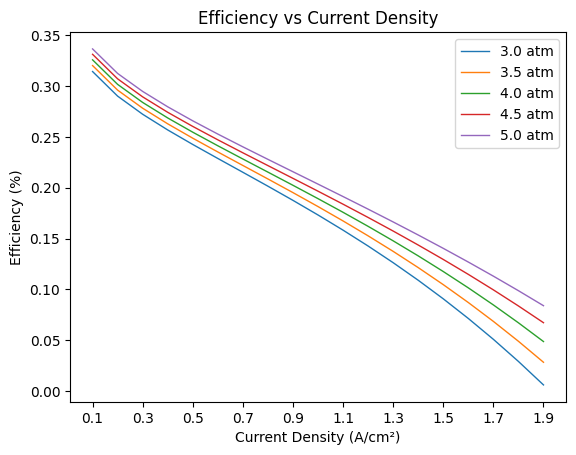

In [21]:
plt.title("Efficiency vs Current Density")
plt.xlabel("Current Density (A/cm\u00b2)")
plt.ylabel("Efficiency (%)")

atm = 3.0
efficiency = energy_efficiency()
for i in np.arange(len(efficiency)):
    plt.plot(current_density, efficiency[i], linewidth=1, label=f"{atm} atm")
    atm = atm + 0.5
plt.xticks(np.arange(min(current_density), max(current_density)+0.1, 0.2))
plt.legend(loc="upper right")
plt.savefig("efficiencyVsCurrent.png", dpi=400)
plt.show()

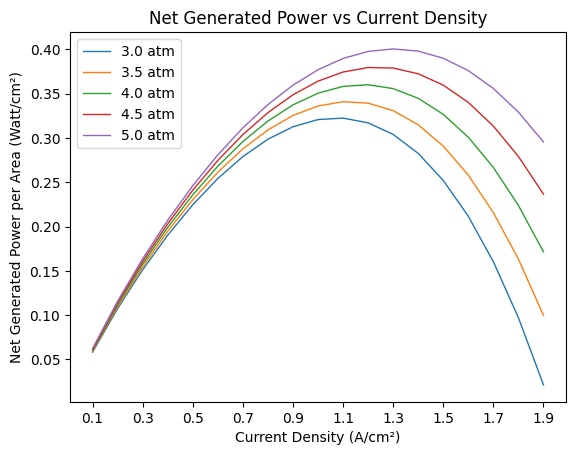

In [22]:
plt.title("Net Generated Power vs Current Density")
plt.xlabel("Current Density (A/cm\u00b2)")
plt.ylabel("Net Generated Power per Area (Watt/cm\u00b2)")

atm = 3.0
pw = power()
for i in np.arange(len(pw)):
    plt.plot(current_density, pw[i], linewidth=1, label=f"{atm} atm")
    atm = atm + 0.5
plt.xticks(np.arange(min(current_density), max(current_density)+0.1, 0.2))
plt.legend(loc="upper left")
plt.savefig("WattvsCurrent.png", dpi=400)
plt.show()

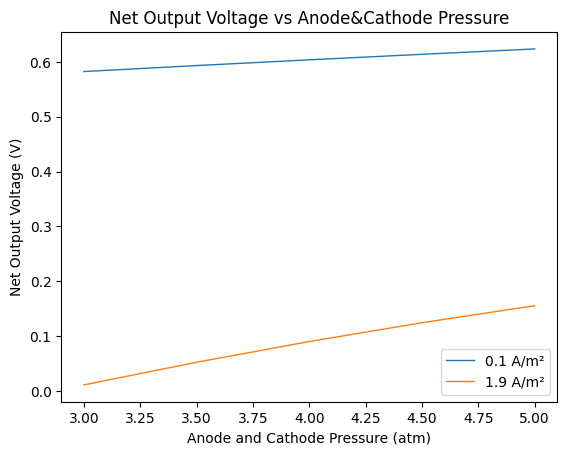

In [23]:
plt.title("Net Output Voltage vs Anode&Cathode Pressure")
plt.xlabel("Anode and Cathode Pressure (atm)")
plt.ylabel("Net Output Voltage (V)")

net_volt = net_voltage()
plt.plot(cell_pressure, net_volt[:,0], linewidth=1, label="0.1 A/m\u00b2")
plt.plot(cell_pressure, net_volt[:,18], linewidth=1, label="1.9 A/m\u00b2")

plt.legend(loc="lower right")
plt.savefig("netVoltageVsPressure.png", dpi=400)
plt.show()